#### Setup

In [1]:
# Get data
!rm data.csv
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-01 12:56:32--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2023-10-01 12:56:32 (35.6 MB/s) - ‘data.csv’ saved [1475504/1475504]



#### Libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler

#### Load Data

In [3]:
# Loading the data
df = pd.read_csv("data.csv")
print(f"Rows: {df.shape[0]:,}")
print(f"Cols: {df.shape[1]}")
df.head(5)

Rows: 11,914
Cols: 16


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


#### Data Preparation

In [4]:
# Select the specified features
VARIABLES = [
    "Make", "Model", "Year", "Engine HP", "Engine Cylinders",
    "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"
]
df = df[VARIABLES]

In [5]:
# Transform column names into a readable format
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [6]:
# Fill in the missing values of the selected features with 0
df.fillna(0, inplace=True)

In [7]:
# Rename MSRP variable to price.
df.rename(columns={"msrp": "price"}, inplace=True)

#### Question 1

In [8]:
df["transmission_type"].value_counts(True)

transmission_type
AUTOMATIC           0.693806
MANUAL              0.246349
AUTOMATED_MANUAL    0.052543
DIRECT_DRIVE        0.005708
UNKNOWN             0.001595
Name: proportion, dtype: float64

In [9]:
df["transmission_type"].mode()

0    AUTOMATIC
Name: transmission_type, dtype: object

#### Question 2

<Axes: >

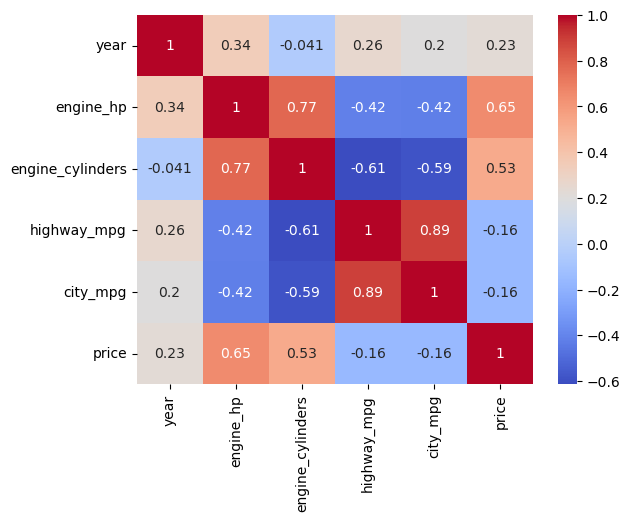

In [10]:
corr = df.select_dtypes("number").corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [11]:
print(corr.loc["engine_hp", "year"])
print(corr.loc["engine_hp", "engine_cylinders"])
print(corr.loc["highway_mpg", "engine_cylinders"])
print(corr.loc["highway_mpg", "city_mpg"])

0.3387141847624335
0.7748509807813221
-0.6145414173953352
0.8868294962591425


#### Make `price` binary

In [12]:
df["above_average"] = (df["price"] > df["price"].mean()).astype(int)

#### Split the data

In [13]:
X, y = df.drop(["above_average", "price"], axis=1), df["above_average"]
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

#### Question 3

In [14]:
NUMERICAL = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
CATEGORICAL = ["make", "model", "transmission_type", "vehicle_style"]

In [15]:
minfo = {}
for var in CATEGORICAL:
    minfo[var] = round(mutual_info_score(X_train[var], y_train), 2)
pd.DataFrame.from_dict(minfo, orient="index", columns=["MI"]).sort_values(by="MI", ascending=False)

,MI
model,0.46
make,0.24
vehicle_style,0.08
transmission_type,0.02


#### Question 4

In [16]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist").fit(X_train[CATEGORICAL])
X_train_ohe = pd.concat(
    [
        pd.DataFrame(
        data=ohe.transform(X_train[CATEGORICAL]),
        columns=ohe.get_feature_names_out(),
        index=X_train.index
        ),
        X_train[NUMERICAL]
    ],
    axis=1
)
X_val_ohe = pd.concat(
    [
        pd.DataFrame(
        data=ohe.transform(X_val[CATEGORICAL]),
        columns=ohe.get_feature_names_out(),
        index=X_val.index
        ),
        X_val[NUMERICAL]
    ],
    axis=1
)

In [17]:
model = LogisticRegression(solver="liblinear", C=10, max_iter=1000, random_state=42)
model.fit(X_train_ohe, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [18]:
accuracy = round((model.predict(X_val_ohe) == y_val).mean(), 2)
accuracy

0.94

#### Question 5

In [19]:
accuracy_diff = {}
for each in ["year", "engine_hp", "transmission_type", "city_mpg"]:
    if each == "transmission_type":
        tmp = [c for c in X_train_ohe.columns if c.startswith("transmission_type")]
        model.fit(X_train_ohe.drop(tmp, axis=1), y_train)
        accuracy_diff[each] = {
            "accuracy": round((model.predict(X_val_ohe.drop(tmp, axis=1)) == y_val).mean(), 2),
            "accuracy_diff": (round((model.predict(X_val_ohe.drop(tmp, axis=1)) == y_val).mean(), 2) - accuracy)
        }
        
    else:
        model.fit(X_train_ohe.drop(each, axis=1), y_train)
        accuracy_diff[each] = {
            "accuracy": round((model.predict(X_val_ohe.drop(each, axis=1)) == y_val).mean(), 2),
            "accuracy_diff": (round((model.predict(X_val_ohe.drop(each, axis=1)) == y_val).mean(), 2) - accuracy)
        }

In [20]:
pd.DataFrame(accuracy_diff).T.sort_values(by="accuracy_diff", ascending=False)

,accuracy,accuracy_diff
year,0.95,0.01
city_mpg,0.95,0.01
transmission_type,0.94,0.00
engine_hp,0.93,-0.01


#### Question 6

In [21]:
X, y = df.drop(["above_average", "price"], axis=1), np.log1p(df["price"])
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [22]:
ohe = OneHotEncoder(min_frequency=0.01, sparse_output=False, handle_unknown="infrequent_if_exist").fit(X_train[CATEGORICAL])
X_train_ohe = pd.concat(
    [
        pd.DataFrame(
        data=ohe.transform(X_train[CATEGORICAL]),
        columns=ohe.get_feature_names_out(),
        index=X_train.index
        ),
        X_train[NUMERICAL]
    ],
    axis=1
)
X_val_ohe = pd.concat(
    [
        pd.DataFrame(
        data=ohe.transform(X_val[CATEGORICAL]),
        columns=ohe.get_feature_names_out(),
        index=X_val.index
        ),
        X_val[NUMERICAL]
    ],
    axis=1
)

In [23]:
scaler = RobustScaler().fit(X_train_ohe[NUMERICAL])
X_train_ohe[NUMERICAL] = scaler.transform(X_train_ohe[NUMERICAL])
X_val_ohe[NUMERICAL] = scaler.transform(X_val_ohe[NUMERICAL])

In [28]:
%%time
rmse_alpha = {}

for alpha in [0, 0.01, 0.1, 1, 10]:
    reg = Ridge(solver="sag", random_state=42, alpha=alpha)
    reg.fit(X_train_ohe, y_train)    
    rmse_alpha[alpha] = round(mean_squared_error(
        y_true=y_val,
        y_pred=reg.predict(X_val_ohe),
        squared=False
    ), 5)

CPU times: user 3.67 s, sys: 2.52 s, total: 6.2 s
Wall time: 3.01 s


In [29]:
pd.DataFrame.from_dict(rmse_alpha, orient="index", columns=["RMSE"]).sort_values(by="RMSE", ascending=True)

,RMSE
0.00,0.45757
0.01,0.45757
0.10,0.45757
1.00,0.45762
10.00,0.45813
